In [27]:
from IPython.display import HTML

path='<iframe style="border: 0; width: 400px; height: 373px;" src="https://bandcamp.com/EmbeddedPlayer/album=1996346495/size=large/bgcol=333333/linkcol=ffffff/artwork=small/transparent=true/" seamless><a href="http://luctus.bandcamp.com/album/ry-ys">Rysys by LUCTUS</a></iframe>'

HTML(path)

Gire (correct dates and Guinea sequences)
& Mali sequences: 1.320
Gire (initial dates, correct Guinea sequences)
& Mali sequences: 1.381
Hoenen et al (2015): 0.946


/Users/admin/Library/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/matplotlib/backends/backend_pdf.py:1100: UserWarning: 'HelveticaNeueLTStd-Th.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


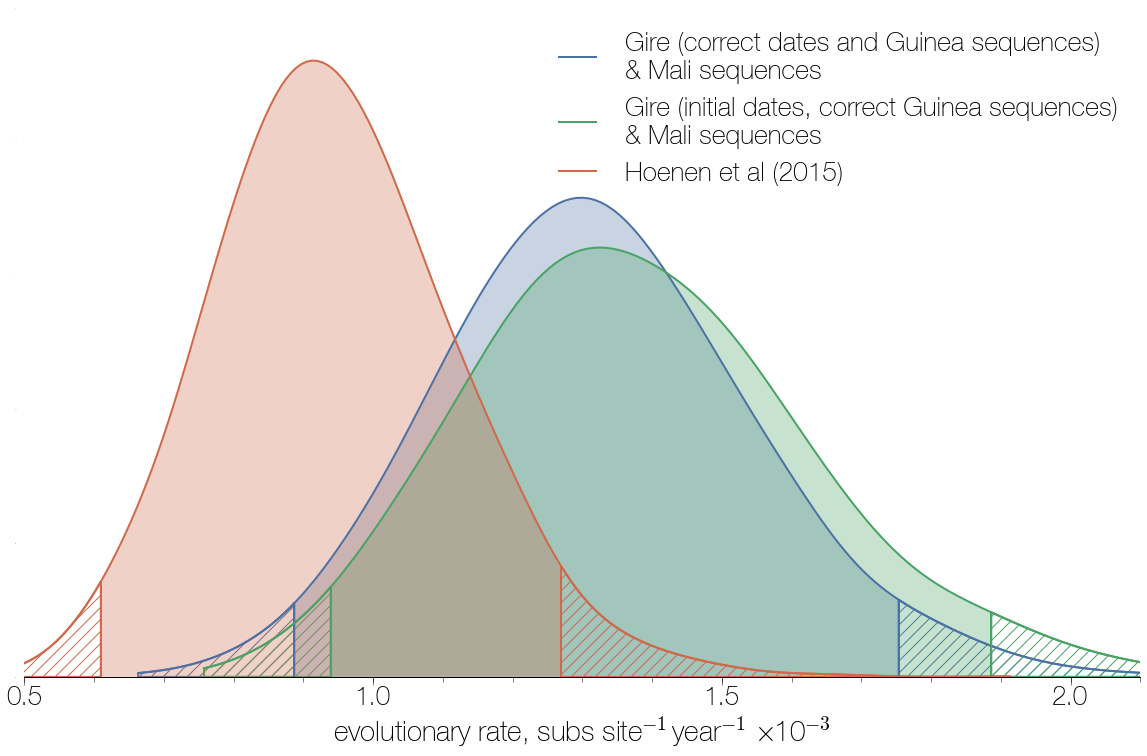

In [3]:
%matplotlib inline
import re
import datetime as dt
import time
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

## set default matplotlib font and font size
typeface='helvetica neue lt std'
# typeface='arial'
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

def decimalDate(date,fmt="%Y-%m-%d"):
    adatetime=dt.datetime.strptime(date,fmt)
    year = adatetime.year
    boy = dt.datetime(year, 1, 1)
    eoy = dt.datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))


def index(data,item):
    """ Get the indices of an item in a list. """
    return [i for i,x in enumerate(data) if x == item]

def column(data,col):
    """ Get column of a list of lists. """
    return [row [col] for row in data]

def unique(o, idfun=repr):
    """Reduce a list down to its unique elements."""
    seen = {}
    return [seen.setdefault(idfun(e),e) for e in o if idfun(e) not in seen]


from scipy.stats import gaussian_kde


def hpd(data, level):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()

    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
 
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k

    assert 0 <= i <= i+nIn-1 < len(d)
 
    return (d[i], d[i+nIn-1])


root='/Users/admin/Dropbox/Ebola_Technical_Comment/OUR_ANALYSES/log_files/'

## define log files
log_paths=[ 'unpart_strict_const_Gire_Mali_correct.log',
            'unpart_strict_const_Gire_Mali_old.log',
            'unpart_strict_const_EBOV_rates_project_full.log']

## define burnin
burnin=10000000

## define labels for each file
log_names={ 'unpart_strict_const_Gire_Mali_correct.log':'Gire (correct dates and Guinea sequences)\n& Mali sequences',
            'unpart_strict_const_EBOV_rates_project_full.log':'Hoenen et al (2015)',
            'unpart_strict_const_Gire_Mali_old.log':'Gire (initial dates, correct Guinea sequences)\n& Mali sequences'}

## define colours for each file
colours={'unpart_strict_const_Gire_Mali_correct.log':(0.2981622478541206, 0.44644367598435458, 0.64719724652229571),
         'unpart_strict_const_Gire_Mali_old.log':(0.28098424626331703, 0.63955403192370541, 0.39507882933990629),
         'unpart_strict_const_EBOV_rates_project_full.log':(0.8162552973803352, 0.41062668737243202, 0.29078047883276847)}

## start figure
fig,ax = plt.subplots(figsize=(20, 12),facecolor='w')

## iterate through files
for log in log_paths:
    ## this will contain posterior samples
    samplesA=[]

    ## iterate through lines of file
    for line in open(root+log,'r'):
        l=line.strip('\n').split('\t')

        ## skip lines with #
        if '#' in line:
            pass
        ## if header = find index of evolutionary rate entries
        elif 'state' in l[0]:
            header=l
            idx=header.index('clock.rate')
        ## else if past burnin - start collecting samples
        elif int(l[0])>=burnin:
            ## multiply by 10^3 for better look
            samplesA.append(float(l[idx])*1000)

    ## identify limits of data - HPDs and min/max values
    hpdLo,hpdHi=hpd(samplesA,0.95)
    m=min(samplesA)
    M=max(samplesA)
    
    ## define grids of equally spaced points for KDE plotting
    x_grid=np.linspace(hpdLo,hpdHi,200)
    full_grid=np.linspace(m,M,200)
    kde=gaussian_kde(samplesA,bw_method=0.3)

    ## fetch colour
    fc=colours[log]

    ## plot KDE as transparent area
    ax.fill_between(x_grid,kde.evaluate(x_grid),facecolor=fc,edgecolor='none',alpha=0.3,label='%s'%(log_names[log]))
    
    ## plot ends of HPDs
    ax.plot([hpdLo,hpdLo],[kde.evaluate(hpdLo),0.0],color=fc,lw=2)
    ax.plot([hpdHi,hpdHi],[kde.evaluate(hpdHi),0.0],color=fc,lw=2)
    
    ## plot outline of KDE
    ax.plot(full_grid,kde.evaluate(full_grid),color=fc,lw=2,label='%s'%(log_names[log]))
    
    ## define hatching for HPDs
    h='//'
    
    ## plot HPD areas with hatching but no fill
    upper=np.linspace(hpdHi,M,100)
    lower=np.linspace(m,hpdLo,100)
    ax.fill_between(upper,kde.evaluate(upper),facecolor='none',lw=2,edgecolor=fc,hatch=h,alpha=1)
    ax.fill_between(lower,kde.evaluate(lower),facecolor='none',lw=2,edgecolor=fc,hatch=h,alpha=1)
    
    ## print file name, mean estimate
    print '%s: %.3f'%(log_names[log],np.mean(samplesA))

## plot legend
ax.legend(frameon=False)

## define x axis minor and major ticks
ax.xaxis.set_ticks(np.arange(0.5,3.0,0.1),minor=True)
ax.xaxis.set_ticks(np.arange(0.5,3.0,0.5),minor=False)

## remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

## tick x axis on the bottom rather than both top and bottom
ax.xaxis.tick_bottom()

## define label sizes for axes
ax.tick_params(axis='x',which='major',labelsize=26,size=8,direction='out')
ax.tick_params(axis='x',which='minor',labelsize=0,size=5,direction='out')
ax.tick_params(axis='y',labelsize=0,size=0,direction='out')

## set x axis limits
ax.set_xlim(0.5,2.1)

## add x axis label
ax.set_xlabel(r'evolutionary rate, subs site$^{-1}$year$^{-1}\times$10$^{-3}$',size=28)

## save to file
plt.savefig('/Users/admin/Downloads/EBOV_GireMali_rates_log.png',dpi=300,bbox_inches='tight')
plt.savefig('/Users/admin/Downloads/EBOV_GireMali_rates_log.pdf',dpi=300,bbox_inches='tight')
plt.show()

## This bit defines the lightweight 'Geri' tree parser

In [15]:
## node class
class node:
    def __init__(self):
        self.rate=None
        self.length=0.0
        self.height=None
        self.absoluteTime=None
        self.parent=None
        
        self.children=[]
        
        self.traits={}
        self.index=None
        self.childHeight=None
        self.numChildren=0
        self.x=None
        self.y=None
        ## contains references to all tips of this node
        self.leaves=[]

## leaf class
class leaf:
    def __init__(self):
        self.name=None
        self.numName=None
        self.index=None
        self.length=0.0
        self.absoluteTime=None
        self.height=None
        self.parent=None
        self.traits={}
        self.x=None
        self.y=None

## tree class
class tree:
    def __init__(self):
        #self.Objects=[]
        
        self.cur_node=node()
        self.cur_node.index='Root'
        self.cur_node.length=0
        self.cur_node.height=0
        
        self.root=self.cur_node
        self.Objects=[]
        self.treeHeight=0

    def move_up(self):
        node=self.cur_node
        self.cur_node=node.parent

    def add_node(self,i):
        new_node=node()
        new_node.index=i

        new_node.parent=self.cur_node

        self.cur_node.children.append(new_node)
        self.cur_node=new_node

        self.Objects.append(self.cur_node)
        
    def add_leaf(self,i,name):
        new_leaf=leaf()
        new_leaf.index=i
        
        new_leaf.name=name
        new_leaf.numName=name
        
        new_leaf.parent=self.cur_node
        
        self.cur_node.children.append(new_leaf)
        self.cur_node=new_leaf

        self.Objects.append(self.cur_node)

    def setAbsoluteTime(self,date):
        #import time
        for i in self.Objects:
            i.absoluteTime=date-self.treeHeight+float(i.traits['height'])

    def treeStats(self):
        self.traverse_tree()
        
        obs=self.Objects
        
        print '\nTree height: %.6f\nTree length: %.6f'%(self.treeHeight,sum([x.length for x in obs]))
        
        nodes=[x for x in obs if isinstance(x,node)]
        
        strictlyBifurcating=False
        maxChildren=max([len(x.children) for x in nodes])
        if maxChildren==2:
            strictlyBifurcating=True
        print 'Tree is strictly bifurcating = %s'%(strictlyBifurcating)
        
        hasTraits=False
        maxAnnotations=max([len(x.traits) for x in obs])
        if maxAnnotations>0:
            hasTraits=True
        print 'Tree has annotations = %s'%(hasTraits)
        
        print 'Numbers of objects in tree: %d (%d nodes and %d leaves)\n'%(len(obs),len(nodes),len(obs)-len(nodes))
            
    def traverse_tree(self):
        cur_node=None
        cur_node=self.root
        seen=[]
        collected=[]
        maxHeight=0
        height=0.0
        root=False

        while root==False:

            if isinstance(cur_node,node):
                
                ## if all children have been seen and not at root
                while sum([1 if x.index in seen else 0 for x in cur_node.children])==len(cur_node.children) and cur_node!=self.root:
                    
                    if cur_node.childHeight <= highestTip:
                        cur_node.childHeight = highestTip
                    elif cur_node.childHeight > highestTip:
                        highestTip = cur_node.childHeight

                    if cur_node.parent.index=='Root':
                        cur_node.height=height
                        root=True
                        break
                    else:
                        cur_node.parent.numChildren+=cur_node.numChildren
                        cur_node.parent.leaves+=cur_node.leaves
                        cur_node.parent.leaves=unique(cur_node.parent.leaves)
                        cur_node.parent.leaves=sorted(cur_node.parent.leaves)
                        cur_node.height=height
                        height-=float(cur_node.length)
                        
                        cur_node=cur_node.parent

                last_seen=[1 if x.index in seen else 0 for x in cur_node.children]
                
                ## should find earliest index of 0 (i.e. unvisited node)
                try:
                    idx_to_visit=last_seen.index(0)
                except ValueError:
                    ## no children seen yet
                    idx_to_visit=0
                
                #print '\nwill visit: %d\nN children: %d\nchildren indices: %s\nlast seen list: %s'%(idx_to_visit,len(cur_node.children),[x.index for x in cur_node.children],last_seen)
                cur_node.height=height
                
                height+=float(cur_node.children[idx_to_visit].length)

                cur_node=cur_node.children[idx_to_visit]

                seen.append(cur_node.index)
                
                
            elif isinstance(cur_node,leaf):
                cur_node.parent.numChildren+=1
                cur_node.parent.leaves.append(cur_node.name)
                cur_node.parent.leaves=sorted(cur_node.parent.leaves)
                seen.append(cur_node.index)
                highestTip=float(height)
                
                cur_node.height=height
                
                if cur_node not in collected:
                    collected.append(cur_node)
                
                if maxHeight<=float(cur_node.height):
                    maxHeight=float(cur_node.height)
                    
                height-=float(cur_node.length)
                cur_node=cur_node.parent
                
        self.treeHeight=float(maxHeight)
        
        return collected

    def renameTips(self,d):
        for k in self.Objects:
            if isinstance(k,leaf):
                k.name=d[k.numName]
        
    
    def sortBranches(self,descending=True):
        if descending==True:
            modifier=1
        elif descending==False:
            modifier=-1

        for k in self.Objects:
            if isinstance(k,node):
                nodes=sorted([x for x in k.children if isinstance(x,node)],key=lambda q:(-len(q.leaves)*modifier,q.length*modifier))
                leaves=sorted([x for x in k.children if isinstance(x,leaf)],key=lambda q:q.length*modifier)

                if modifier==1:
                    k.children=nodes+leaves
                elif modifier==-1:
                    k.children=leaves+nodes
        
        
    def drawTree(self):
        ## order is a list of tips recovered from a tree traversal to make sure they're plotted in the correct order along the vertical tree dimension
        order=[x.numName for x in self.traverse_tree() if isinstance(x,leaf)]
        
        ## reset coordinates for all objecs
        for k in self.Objects:
            k.x=None
            k.y=None
        
        ## drawn keeps track of what's been drawn
        drawn=[]

        # keep drawing the tree until everything is drawn
        while len(drawn)!=len(self.Objects):
            ## iterate through objects
            for k in [x for x in self.Objects if x.index not in drawn]:
                
                ## if leaf - get position of leaf, draw branch connecting tip to parent node
                if isinstance(k,leaf):
                    x=k.height
                    xp=k.parent.height
                    y=order.index(k.numName)
                    k.x=x
                    k.y=y
                    drawn.append(k.index)

                ## if parent is non-root node
                if isinstance(k,node):
                    if len([q.y for q in k.children if q.y!=None])>=2 and k!=self.root:

                        x=k.height
                        xp=k.parent.height                    

                        y=np.mean([q.y for q in k.children if q.y!=None])

                        k.x=x
                        k.y=y
                        drawn.append(k.index)
        
        
def make_tree(data,ll):
    """
    data is tree string
    ll is an instance of a tree object
    """
    global i
    stored_i=None
    ministore=None
    while i < len(data):
        assert (stored_i != i),'\nTree string unparseable\nStopped at >>%s<<\nstring region looks like this: %s'%(data[i],data[i:i+2000])
        stored_i=i
        
        ## look for new nodes
        if data[i] == '(':
            ll.add_node(i)
            i+=1
            
        ## look for tips
        cerberus=re.match('([0-9]+)\[',data[i:i+250])
        if cerberus is not None:
            ll.add_leaf(i,cerberus.group(1))
            i+=len(cerberus.group(1))
            
        ## look for tips with unencoded names
        cerberus=re.match('(\'|\"|)([A-Za-z\_\-\|\.0-9\?\/]+)(\'|\"|)(\[)*',data[i:i+1000])
        if cerberus is not None:
            ll.add_leaf(i,cerberus.group(2))
            i+=len(cerberus.group(2))+cerberus.group().count("'")+cerberus.group().count('"')
            
            
        ## look for comments
        cerberus=re.match('\[&[A-Za-z\_\-{}\,0-9\.\%=\"]+\]',data[i:i+5000])
        if cerberus is not None:
            comment=cerberus.group()
            numerics=re.findall('[A-Za-z\_\.]+=[0-9\-Ee\.]+',comment)
            strings=re.findall('[A-Za-z\_\.]+="[A-Za-z\_]+"',comment)
            
            for vals in numerics:
                tr,val=vals.split('=')
                ll.cur_node.traits[tr]=float(val)
                if tr=='length':
                    ll.cur_node.length=float(val)
                elif tr=='height':
                    ll.cur_node.height=float(val)
                
            for vals in strings:
                tr,val=vals.split('=')
                ll.cur_node.traits[tr]=val.strip('"')
            
            i+=len(comment)
            
            
        ## look for branch lengths without comments
        microcerberus=re.match('\:([0-9\.\-Ee]+)',data[i:i+1000])
        if microcerberus is not None:
            ll.cur_node.length=float(microcerberus.group(1))
            i+=len(microcerberus.group())
            
        ## look for branch lengths
        microcerberus=re.match('\:\[&([A-Za-z\_\-{}\,0-9\.\%=\"]+)\]([0-9\.\-Ee]+)',data[i:i+5000])
        if microcerberus is not None:
            comment=microcerberus.group(1)
            numerics=re.findall('[A-Za-z\_\.]+=[0-9\-Ee\.]+',comment)
            strings=re.findall('[A-Za-z\_\.]+="[A-Za-z\_]+"',comment)
            
            for vals in numerics:
                tr,val=vals.split('=')
                ll.cur_node.traits[tr]=float(val)
                if tr=='length':
                    ll.cur_node.length=float(val)
                elif tr=='height':
                    ll.cur_node.height=float(val)
                
            for vals in strings:
                tr,val=vals.split('=')
                ll.cur_node.traits[tr]=val.strip('"')
            
            i+=len(microcerberus.group())

        ## look for bifurcations
        if data[i] == ',':
            i+=1
            ll.move_up()
            
        ## look for clade ends
        if data[i] == ')':
            ll.move_up()
            i+=1

        ## look for string end
        if data[i] == ';':
            leafCounter=0
            nodeCounter=0
            for lf in ll.Objects:
                if isinstance(lf,leaf):
                    leafCounter+=1
                else:
                    nodeCounter+=1
                    
            break
            
print 'Done!'

Done!


In [25]:
## all trees are kept in same directory
root='/Users/admin/Dropbox/Ebola_Technical_Comment/OUR_ANALYSES/ML_trees/'

## Hoenen vs Correct
## Old vs Correct
## Shuffle vs Correct
tree_paths=[('PhyML_EBOV_rates_project_full.newick','PhyML_Gire_Mali_correct.newick'),
            ('PhyML_Gire_Mali_old.newick','PhyML_Gire_Mali_correct.newick'),
            ('PhyML_Gire_Mali_correct.newick','PhyML_Gire_Mali_correct_shuffled.newick')]

## translate the name of each tree file into dataset
tree_names={'PhyML_Gire_Mali_correct.newick':'Gire (correct dates) & Mali',
            'PhyML_Gire_Mali_old.newick':'Gire (initial dates) & Mali',
            'PhyML_EBOV_rates_project_full.newick':'Hoenen et al (2015)',
            'PhyML_Gire_Mali_correct_shuffled.newick':'Randomized tip labels'}

trees=[]

replicate_seqs={}

## create a dict of dicts to identify sequences within each tree that come from the same patient
for tree_pair in tree_paths:
    for tr in tree_pair:
        replicate_seqs[tr]={}

## iterate over tree pairs
for tree_pair in tree_paths:

    ## create empty tree objects for both members
    treeA=tree()
    treeB=tree()
    
    ## assign to a pair tuple
    object_pair=(treeA,treeB)
    
    ## add to overall list
    trees.append(object_pair)
    
    ## iterate over the pair
    for cur_tree,cur_path in zip(object_pair,tree_pair):
        tipFlag=False
        i=0
        tips={}
        tipNum=0

        ## import tree
        for line in open(root+cur_path,'r'):
            l=line.strip('\n')
            ## make tree
            make_tree(l,cur_tree)


        ## iterate over leaves of the tree
        for k in cur_tree.Objects:
            if isinstance(k,leaf):
                
                actual_name=k.name
                
                ## search strain name in tree
                cerberus=re.search('([A-Z]+[0-9]+)([A-Za-z0-9\.\-\_\|]+)\|([0-9\-]+)',actual_name)
                if cerberus is None:
                    print actual_name,'not caught by regex'
                    
                ## replace the tip name with accession and date, such that the same tips can be identified between trees
                k.name='%s|%s'%(cerberus.group(1),cerberus.group(3))
                    
                    
                ## the following bit identifies tips that have come from the same patients,
                # these are easy to spot since they contain a strain ID, followed by a dot, followed by a number
                # e.g. EM124.1, EM124.2, etc.
                strain_junk=cerberus.group(2)

                strain=''
                
                ## look for XML-like tip names
                cerberus=re.search('\_([A-Z0-9]+p[0-9]+)\_',strain_junk)
                if cerberus is None:
                    ## if no match - try looking for other formatting
                    cerberus=re.search('\-([A-Z0-9]+\.[0-9]+)',strain_junk)
                    if cerberus is not None:
                        strain=cerberus.group(1)
                elif cerberus is not None:
                    ## found XML-like formatting, replace the letter 'p' with the character '.'
                    strain=cerberus.group(1).replace('p','.')
                
                ## if a strain name has been correctly identified
                if strain!='':
                    
                    ## check whether the strain is already known in this tree
                    if replicate_seqs[cur_path].has_key(strain.split('.')[0]):
                        ## check whether the current tip is a known replicate of the strain
                        if k.name not in replicate_seqs[cur_path][strain.split('.')[0]]:
                            replicate_seqs[cur_path][strain.split('.')[0]].append(k.name)
                    
                    ## first time encountering this strain in the tree
                    else:
                        replicate_seqs[cur_path][strain.split('.')[0]]=[k.name]

        ## get tip names
        tip_names=[x.name for x in cur_tree.Objects if isinstance(x,leaf)]

        print cur_path
        cur_tree.treeStats()
        ## traverse tree to set branch heights, treeStats() traverses the tree too
#         cur_tree.traverse_tree()
        
        ## fetch a list of all nodes
        nodes=[x for x in cur_tree.Objects if isinstance(x,node) and x!=cur_tree.root]
        
        ## count how many internal branches have zero length (i.e. are randomly resolved polytomies)
        zero_count=sum([1 if q.length==0.0 else 0 for q in nodes])

        ## as long as there are polytomies - keep reducing the tree
        while zero_count>0:
            
            ## start with branches near the tips
            for k in sorted(nodes,key=lambda x:x.height):
                
                ## if branch has zero length
                if k.length==0.0:
                    
                    ## fetch the node's children
                    zero_node=k.children
                    
                    ## add them to the zero node's parent
                    k.parent.children+=zero_node
                    
                    old_parent=k
                    new_parent=k.parent
                    
                    ## assign the parent of zero node as the parent to any children of zero node
                    for w in cur_tree.Objects:
                        if w.parent==old_parent:
                            w.parent=new_parent

                    
                    ## remove traces of zero node - it doesn't exist as a child, doesn't exist in the tree and doesn't exist in the nodes list
                    k.parent.children.remove(k)
                    cur_tree.Objects.remove(k)
                    nodes.remove(k)

                    ## one more zero node taken care of
                    zero_count-=1
        
        ## sort children
        for k in nodes:
            ## get all leaf children, sort by branch length, then alphabetically
            leaves=sorted([x for x in k.children if isinstance(x,leaf)],key=lambda y:(y.length,y.name))
            
            ## get all node children, sort by branch length, number of children, then alphabetically by first child name
            nod=sorted([x for x in k.children if isinstance(x,node)],key=lambda y:(y.length,len(y.children),sorted(y.leaves)[0]))

            ## combine again - first leaves, then nodes
            k.children=leaves+nod
        
        ## calculate x and y positions of each branch following sorting
        cur_tree.drawTree()

PhyML_EBOV_rates_project_full.newick

Tree height: 0.001031
Tree length: 0.003495
Tree is strictly bifurcating = True
Tree has annotations = False
Numbers of objects in tree: 211 (105 nodes and 106 leaves)

PhyML_Gire_Mali_correct.newick

Tree height: 0.001031
Tree length: 0.003495
Tree is strictly bifurcating = True
Tree has annotations = False
Numbers of objects in tree: 211 (105 nodes and 106 leaves)

PhyML_Gire_Mali_old.newick

Tree height: 0.001031
Tree length: 0.003495
Tree is strictly bifurcating = True
Tree has annotations = False
Numbers of objects in tree: 211 (105 nodes and 106 leaves)

PhyML_Gire_Mali_correct.newick

Tree height: 0.001031
Tree length: 0.003495
Tree is strictly bifurcating = True
Tree has annotations = False
Numbers of objects in tree: 211 (105 nodes and 106 leaves)

PhyML_Gire_Mali_correct.newick

Tree height: 0.001031
Tree length: 0.003495
Tree is strictly bifurcating = True
Tree has annotations = False
Numbers of objects in tree: 211 (105 nodes and 106 le

strain G3670 was removed from PhyML_Gire_Mali_old.newick, because it does not have replicate sequences
strain G3679 was removed from PhyML_Gire_Mali_old.newick, because it does not have replicate sequences
strain G3680 was removed from PhyML_Gire_Mali_old.newick, because it does not have replicate sequences
strain G3682 was removed from PhyML_Gire_Mali_old.newick, because it does not have replicate sequences
strain G3683 was removed from PhyML_Gire_Mali_old.newick, because it does not have replicate sequences
strain G3686 was removed from PhyML_Gire_Mali_old.newick, because it does not have replicate sequences
strain G3687 was removed from PhyML_Gire_Mali_old.newick, because it does not have replicate sequences
strain G3734 was removed from PhyML_Gire_Mali_old.newick, because it does not have replicate sequences
strain G3765 was removed from PhyML_Gire_Mali_old.newick, because it does not have replicate sequences
strain G3789 was removed from PhyML_Gire_Mali_old.newick, because it does

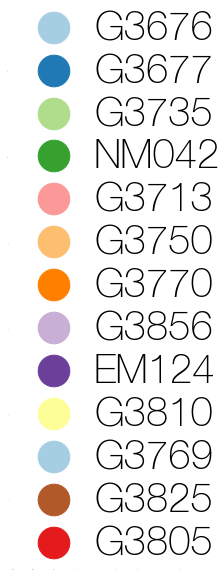

In [17]:
## iterate over potential replicates
for tree_file in replicate_seqs.keys():
    
    strains=sorted(replicate_seqs[tree_file].keys())
    
    for strain in strains:
        ## if the strain only has one match in the entire tree - remove it, it's just a regular tip
        if len(replicate_seqs[tree_file][strain])==1:
            replicate_seqs[tree_file].pop(strain,None)
            print 'strain %s was removed from %s, because it does not have replicate sequences'%(strain,tree_file)

## iterate over potential replicates
for tree_file in replicate_seqs.keys():
    
    strains=sorted(replicate_seqs[tree_file].keys())
    print '%s identified as strains with replicate sequences in tree %s'%(strains,tree_file)
    
## strains that have more than one sequence
multi_strains=['G3676', 'G3677', 'G3735', 'NM042', 'G3713', 'G3750', 'G3770', 'G3856', 'EM124', 'G3810', 'G3769', 'G3825', 'G3805']

multi_colours={}
clist=[(0.65098041296005249, 0.80784314870834351, 0.89019608497619629), 
 (0.12572087695201239, 0.47323337360924367, 0.707327968232772), 
 (0.68899655751153521, 0.8681737867056154, 0.54376011946622071), 
 (0.21171857311445125, 0.63326415104024547, 0.1812226118410335), 
 (0.98320646005518297, 0.5980161709820524, 0.59423301088459368), 
 (0.99175701702342312, 0.74648213716698619, 0.43401768935077328), 
 (0.99990772780250103, 0.50099192647372981, 0.0051211073118098693), 
 (0.78329874347238004, 0.68724338552531095, 0.8336793640080622), 
 (0.42485198495434734, 0.2511495584950722, 0.60386007743723258), 
 (0.99760092286502611, 0.99489427150464516, 0.5965244373854468),
 (0.65098041296005249, 0.80784314870834351, 0.89019608497619629),
 (0.69411766529083252, 0.3490196168422699, 0.15686275064945221), 
 (0.89059593116535862, 0.10449827132271793, 0.11108035462744099)]

fig,ax = plt.subplots(figsize=(3, 10),facecolor='w')

for s,st in enumerate(multi_strains):
    multi_colours[st]=clist[s]
    x=1
    y=13-s
    ax.scatter(x,y,1000,color=clist[s])
    ax.text(x+0.2,y,'%s'%(st),size=40,ha='left',va='center')
    
ax.set_xlim(0.8,1.6)
ax.set_ylim(0.5,13.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(labelsize=0,size=0)
# plt.savefig('/Users/admin/Downloads/EBOV_rates_cmap.pdf',dpi=50,bbox_inches='tight')
plt.show()

## sort strains by number of tips
multi_strains=sorted(multi_strains,key=lambda x:-len(replicate_seqs['PhyML_Gire_Mali_correct.newick'][x]))

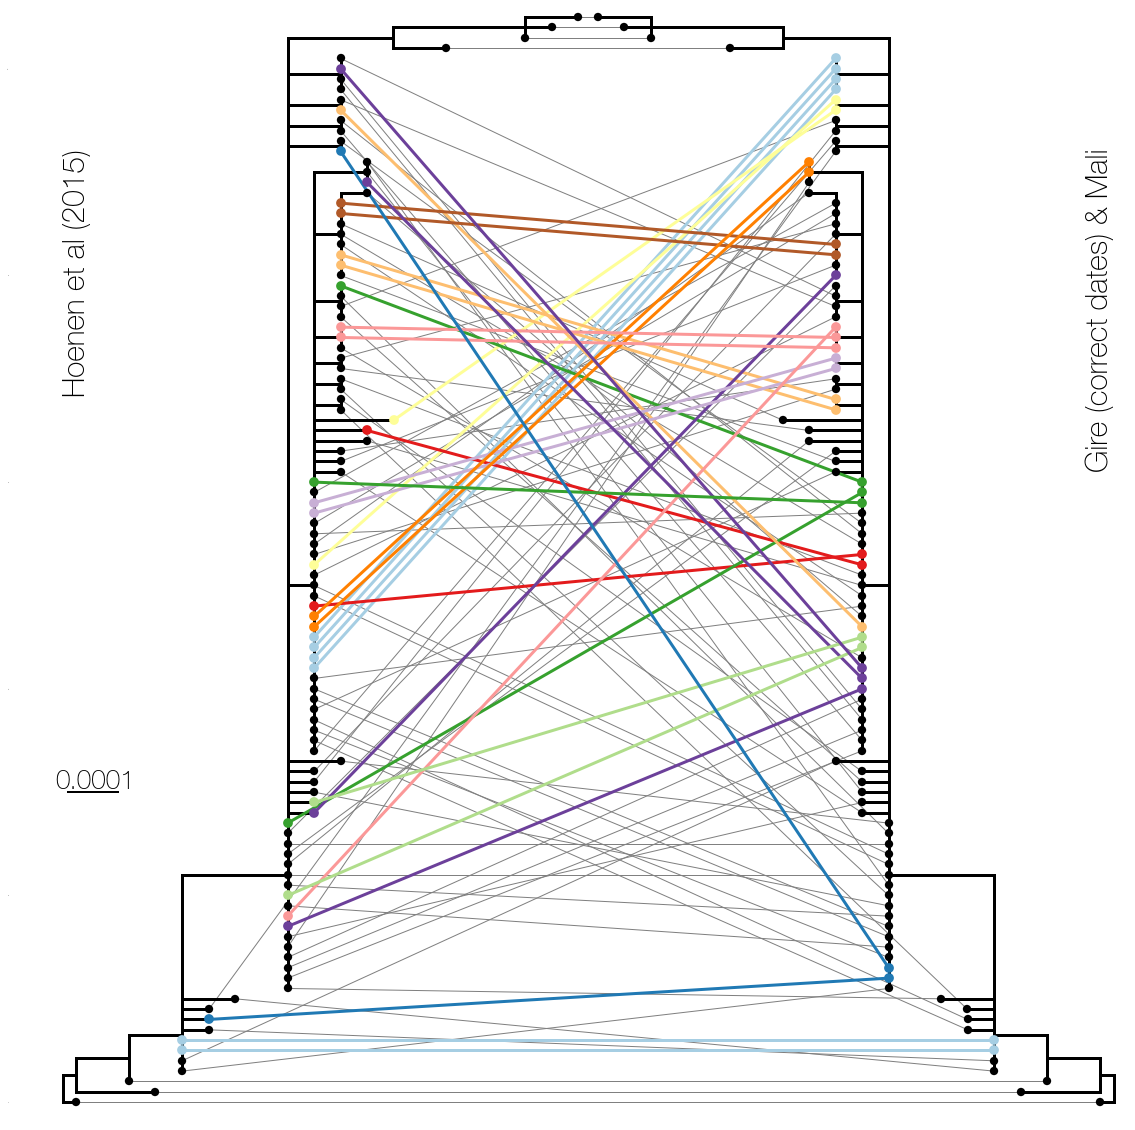

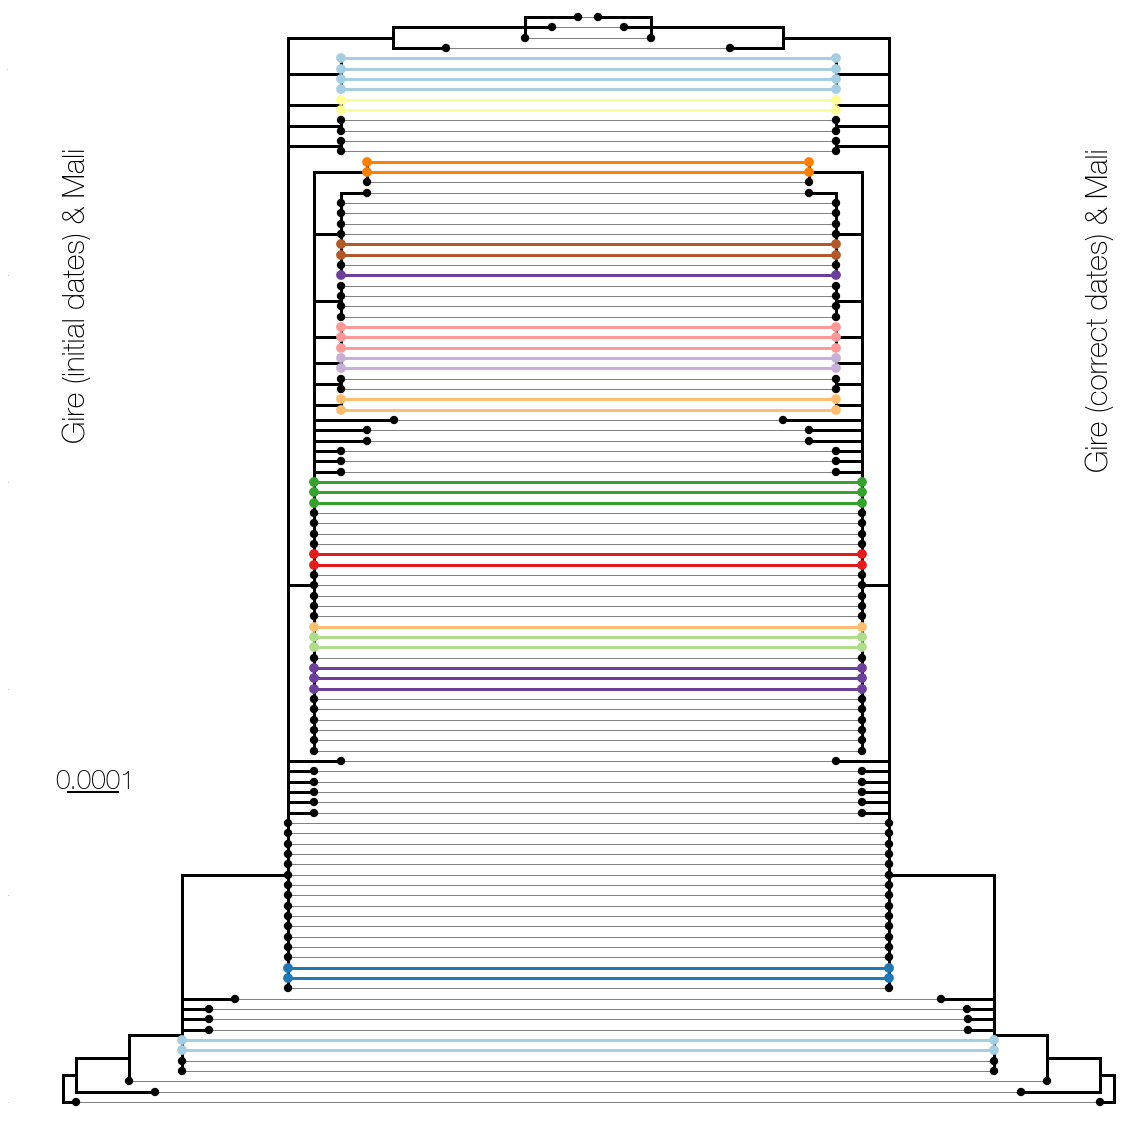

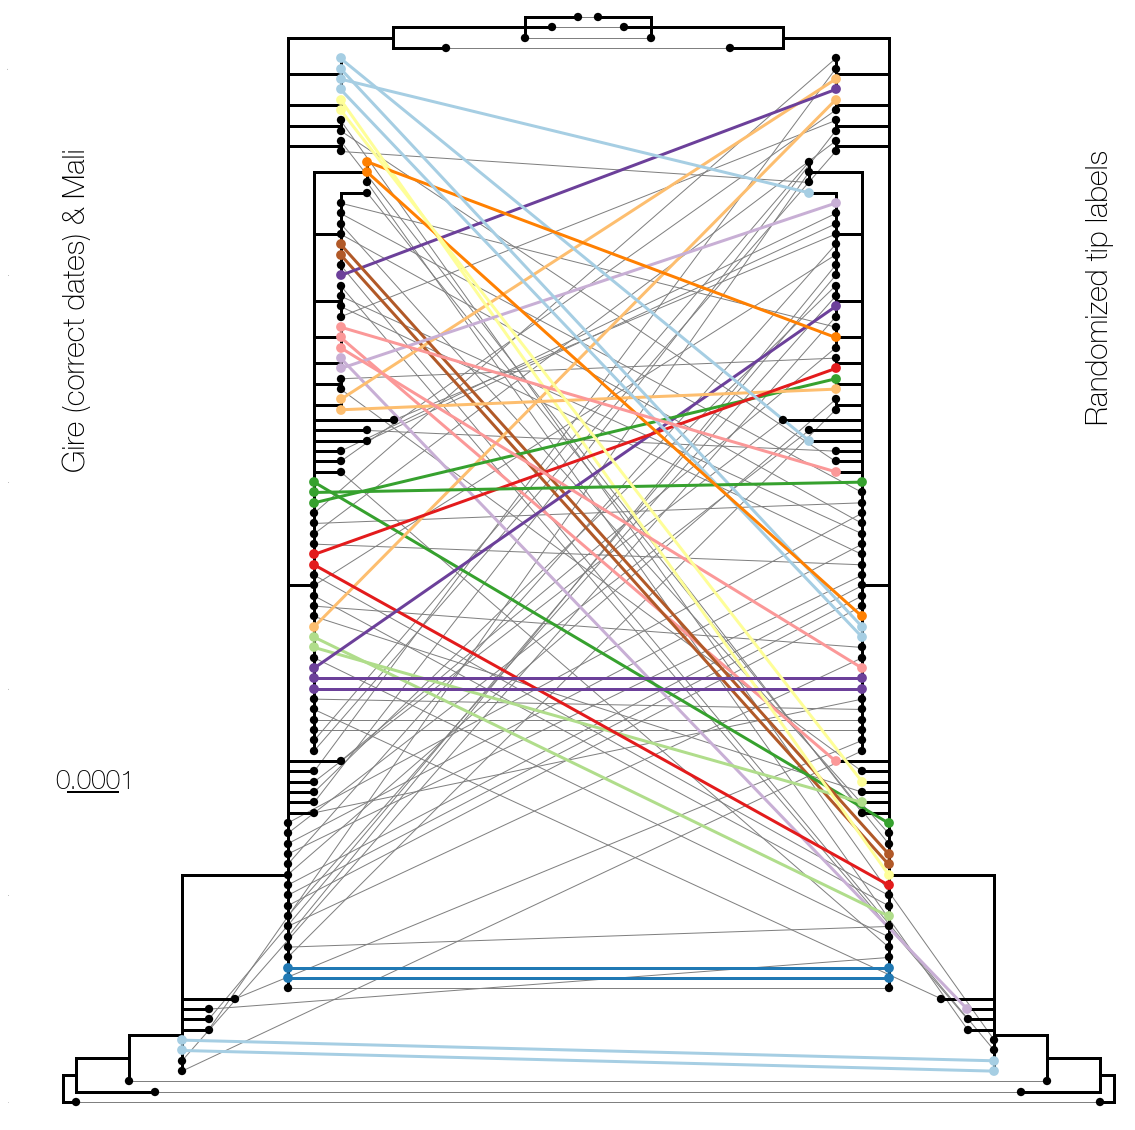

In [24]:
def convertDate(x,start,end):
    """ Converts calendar dates between supplied formats. """
    return dt.datetime.strftime(dt.datetime.strptime(x,start),end)


treeA=trees[0][0]
A_names=[w.name.split('|')[0] for w in treeA.traverse_tree() if isinstance(w,leaf)]

## default branch width
branchWidth=3

## iterate over tree pairs
for tree_pair,tree_pair_names in zip(trees,tree_paths):

    fig,ax = plt.subplots(figsize=(20, 20),facecolor='w')

    ## extract path of each file (used to find tips from the same patients)
    treeA_path,treeB_path=tree_pair_names
    
    ## extract file name (used to label trees)
    treeA_name,treeB_name=[tree_names[x] for x in tree_pair_names]
    
    ## extract trees
    treeA,treeB=tree_pair
    
    ## define tip circle size
    tipsize=40
    modify=0

    ## iterate over branches of left tree
    for k in treeA.Objects:

        x=k.height
        y=k.y
        xp=k.parent.height
            
        ## if external branch...
        if isinstance(k,leaf):
            A_name=k.name.split('|')[0]
            
            ## tip circle outline is black
            ec='k'
            
            for strain in replicate_seqs[treeA_path].keys():
                ## if tip is part of a set of replicate sequences from the same patient - change colour, increase tip circle size
                if k.name in replicate_seqs[treeA_path][strain]:
                    ec=multi_colours[strain]
                    modify=20

            ## plot circle
            ax.scatter(x,y,tipsize+modify,facecolor=ec,edgecolor=ec,lw=2,zorder=100)
            modify=0
            
            ## plot ancestral branch
            ax.plot([x,xp],[y,y],color='k',lw=branchWidth)

        ## if internal branch...
        elif isinstance(k,node):
            yl=k.children[0].y
            yr=k.children[-1].y
            
            ## plot ancestral branch
            ax.plot([x,xp],[y,y],color='k',lw=branchWidth)
            ## plot vertical bar
            ax.plot([x,x],[yl,yr],color='k',lw=branchWidth)
    
    ## plot connection at root
    ax.plot([treeA.root.height,treeA.root.height],[treeA.root.children[0].y,treeA.root.children[-1].y],color='k',lw=branchWidth)
    

    ## add scale bar
    start=0.00001
    end=start+0.0001
    ypos=30
    ax.plot([start,end],[ypos,ypos],color='k',lw=2)
    ax.text((start+end)/2.0,ypos-0.1,end-start,color='k',va='bottom',ha='center',size=26)
    
    ## define distance from which to plot right tree
    adjustX=0.0021

    ## add tree labels, left tree name on the left, etc.
    ax.text(0.0,90,treeA_name,ha='left',size=30,rotation=90)
    ax.text(adjustX,90,treeB_name,ha='right',size=30,rotation=90)
    
    ## iterate over branches of right phylogeny
    for k in treeB.Objects:

        x=adjustX-k.height
        y=k.y
        xp=adjustX-k.parent.height
        
        ## if external branch...
        if isinstance(k,leaf):
            B_name=k.name.split('|')[0].strip("'")
            
            ## all circles have a black outline unless...
            ec='k'
            
            ## identify tips that are from the same patient, change colour, increase tip circle size
            for strain in replicate_seqs[treeB_path].keys():
                if k.name in replicate_seqs[treeB_path][strain]:
                    ec=multi_colours[strain]
                    modify=20
            
            ## look for matching tip names in left phylogeny
            match=''
            for j in treeA.Objects:
                if isinstance(j,leaf):
                    if B_name in j.name:
                        cx=j.x
                        cy=j.y
                        match=j.name.split('|')[0]
                        
                        ## if tip circle outline has been changed - change tangleline colour too
                        if ec!='k':
                            col=ec
                            
                        ## regular tip (not replicate from same patient) - tanglelines are grey
                        else:
                            col='grey'
                        
                        ## connect matching tips between right and left phylogenies
                        ax.plot([cx,x],[cy,y],color=col,lw=1+modify/10.0,zorder=modify,ls='-')

            ## if a match was found in the left phylogeny - plot tip circle for right phylogeny
            # makes it easy to spot whether something was missed
            if match!='':
                ax.scatter(x,y,tipsize+modify,facecolor=ec,edgecolor=ec,lw=2,zorder=100)
                modify=0
        
            ## plot ancestral tip branch
            ax.plot([x,xp],[y,y],color='k',lw=branchWidth)

        ## if internal branch...
        elif isinstance(k,node):
            yl=k.children[0].y
            yr=k.children[-1].y

            ## plot ancestral branch
            ax.plot([x,xp],[y,y],color='k',lw=branchWidth)
            ## plot vertical bar
            ax.plot([x,x],[yl,yr],color='k',lw=branchWidth)
    
    ## plot vertical bar at root
    ax.plot([adjustX-treeB.root.height,adjustX-treeB.root.height],[treeB.root.children[0].y,treeB.root.children[-1].y],color='k',lw=branchWidth)
    
    ## remove x axis labels
    ax.set_xticklabels([])
    
    ## set plot limits
    ax.set_xlim(-0.0001,adjustX+0.00003)
    ax.set_ylim(-2,106)
    
    ## remove plot frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ## remove ticks from axes
    ax.tick_params(labelsize=0,size=0)

    ## save to file
    #plt.savefig('/Users/admin/Downloads/EBOV_rates_%s_tree.png'%(treeA_name),dpi=300,bbox_inches='tight')
    #plt.savefig('/Users/admin/Downloads/EBOV_rates_%s_tree.pdf'%(treeA_name),dpi=300,bbox_inches='tight')
    
    plt.show()

In [1]:
import os
import glob
from Bio import SeqIO

## path to files with replicate sequences
path='/Users/admin/Documents/Viral_sequences/EBOV/GenBank/'

data={}
sequences={}

## walk through directories
for subdir, dirs, files in os.walk(path):
    for file in files:
        
        ## isolate name is subdirectory name
        isolate=subdir.split('/')[-1]
        
        ## haven't seen this isolate before - add key to data dict
        if data.has_key(isolate)==False:
            data[isolate]={}
            sequences[isolate]={}
        ## go through the record
        for seq_record in SeqIO.parse(os.path.join(subdir, file), "genbank"):
            #accession=seq_record.annotations['accessions'][0]
            #gi=seq_record.annotations['gi']
            collection=seq_record.features[0].qualifiers['collection_date'][0]
            submission=seq_record.annotations['date']
            
            ## add reported collection date of this version with the edit date as the key
            data[isolate][submission]=collection
            
            ## add the sequence version in the dict with its date as the key
            sequences[isolate][submission]=str(seq_record.seq)
            
print 'Done!'

Done!


In [23]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.datetime.strftime(dt.datetime.strptime(x,start),end)

data_keys=sorted(data.keys())

#############
## Check whether sequences were changed on GenBank, report if they have
#############

## iterate over each sequence
for i,k in enumerate(data_keys):
    ## dates when entry was edited
    all_dates=sorted(data[k].keys(),key=lambda x:decimalDate(x,'%d-%b-%Y'))
    
    ## get dates of editing if the SEQUENCE has been changed
    dates_of_editing=[all_dates[x+1] for x in range(len(all_dates)-1) if sequences[k][all_dates[x]]!=sequences[k][all_dates[x+1]]]
    
    ## report if sequence has been changed at any point
    if len(dates_of_editing)>0:
        print '%s sequence has been modified on: %s'%(k,', '.join(dates_of_editing))


#############
## Check whether collection dates were changed on GenBank, report if they have
#############
        
## iterate over each sequence
for i,k in enumerate(data_keys):
    ## dates when entry was edited
    all_dates=sorted(data[k].keys(),key=lambda x:decimalDate(x,'%d-%b-%Y'))
    
    ## find dates when entry was edited
    dates_of_editing=[all_dates[x+1] for x in range(len(all_dates)-1) if data[k][all_dates[x]]!=data[k][all_dates[x+1]]]
    
    ## if dates were edited at all - report
    if len(dates_of_editing)>0:
        print '%s collection date has been modified on: %s'%(k,', '.join(dates_of_editing))


#############
## Report table summarising GenBank record changes
#############    

LaTeX=False

if LaTeX==True:
    
    print "\\begin{table}[h]\n\t\centering"
    
    print "\t\\begin{tabular}{| p{2cm} | p{2cm} | p{2cm} | p{2cm} | p{2cm} | p{2cm} |} \\hline"
    
    print '\tSequence name & Original reported collection date & Collection date after correction & Difference (days) & Date of GenBank record submission & Date when collection date was changed on Genbank \\\\ \hline'
elif LaTeX==False:
    print '\nSequence name\tOriginal reported collection date\tCollection date after correction\tDifference (days)\tDate of GenBank record submission\tDate when collection date was changed on Genbank'
    
## iterate over each sequence
for i,k in enumerate(data_keys):
    
    ## find dates of edit
    all_dates=sorted(data[k].keys(),key=lambda x:decimalDate(x,'%d-%b-%Y'))
    
    ## get first and last day of editing
    original=decimalDate(data[k][all_dates[0]],'%d-%b-%Y')
    recent=decimalDate(data[k][all_dates[-1]],'%d-%b-%Y')
    
    ## find difference in days between edits
    diff=int(365*(recent-original))
    
    ## if difference is not zero
    if diff!=0:
        if diff>0:
            diff='+%s'%(diff)
        else:
            diff='%s'%(diff)
        
        ## convert dates into the same format, report
        submission=convertDate(all_dates[0],'%d-%b-%Y','%Y-%m-%d')
        edit=convertDate(all_dates[-1],'%d-%b-%Y','%Y-%m-%d')
        
        reported_date1=convertDate(data[k][all_dates[0]],'%d-%b-%Y','%Y-%m-%d')
        reported_date2=convertDate(data[k][all_dates[-1]],'%d-%b-%Y','%Y-%m-%d')
        if LaTeX==False:
            print '%s\t%s\t%s\t%s\t%s\t%s'%(k,reported_date1,reported_date2,diff,submission,edit)
        elif LaTeX==True:
            print '\t%s & %s & %s & %s & %s & %s \\\\ \hline'%(k,reported_date1,reported_date2,diff,submission,edit)
            
if LaTeX==True:
    print "\t\label{deltas}\n\t\end{tabular}\n\t\caption{}\n\end{table}"

em095 collection date has been modified on: 15-DEC-2014
em095b collection date has been modified on: 15-DEC-2014
em096 collection date has been modified on: 15-DEC-2014
em098 collection date has been modified on: 15-DEC-2014
g3670 collection date has been modified on: 15-DEC-2014
g3676.1 collection date has been modified on: 15-DEC-2014
g3676.2 collection date has been modified on: 15-DEC-2014
g3677.1 collection date has been modified on: 15-DEC-2014
g3677.2 collection date has been modified on: 15-DEC-2014
g3679 collection date has been modified on: 15-DEC-2014
g3680 collection date has been modified on: 15-DEC-2014
g3682 collection date has been modified on: 15-DEC-2014
g3683 collection date has been modified on: 15-DEC-2014
g3686 collection date has been modified on: 15-DEC-2014
g3687 collection date has been modified on: 15-DEC-2014
g3707 collection date has been modified on: 06-APR-2015

Sequence name	Original reported collection date	Collection date after correction	Difference (d